Import

In [1]:
%load_ext autoreload
%autoreload 2
import ferbo as fb
import numpy as np
import functools
import matplotlib.pyplot as plt
from scipy import special
from scipy.constants import hbar, e, k, h
from scipy.optimize import minimize, basinhopping
from scipy.special import hermite, factorial

# Constants

In [2]:
T_k = 15e-3
phi_0 = h/2/e
Rq = h/4/e**2

# Functions

In [3]:
def phi_n(Ec,El, n: int,phi_list):
    # CONVERT THE FOCK SPACE STATES IN HARMONIC OSCILLATOR WAVEFUNCTIONS
    phi_ZPF=(8.0 * Ec / El) ** 0.25      
    normalization  = 1/np.sqrt(np.sqrt(np.pi)*(2**n) * 1.0 * phi_ZPF * factorial(n))
    return normalization* np.exp(-(phi_list/phi_ZPF)**2 / 2.0) * np.polyval(hermite(n), (phi_list/phi_ZPF))


def wavefunction_phi_fbq_up(Ec,El,phi_list,phi,N):
    # Wavefunction(\varphi) FOR \sigmaz = +1 OF AN EIGENSTATE OF THE Fermionic-Bosonic Qubit.

    wfunc = np.zeros(len(phi_list),dtype = complex)
    for n in range(N//2+1):
        wfunc = wfunc + phi_n(Ec,El,n,phi_list)*phi.full()[2*n,0]
    return wfunc

def wavefunction_phi_fbq_down(Ec,El,phi_list,phi,N):
    # Wavefunction(\varphi) FOR \sigmaz = -1 OF AN EIGENSTATE OF THE Fermionic-Bosonic Qubit.

    wfunc = np.zeros(len(phi_list),dtype = complex)
    for n in range(N//2):
        wfunc = wfunc + phi_n(Ec,El,n,phi_list)*phi.full()[2*n+1,0]
    return wfunc

In [4]:
@functools.lru_cache(maxsize=None)
def Temp_factor(E01):
    return 1/np.tanh(h*np.abs(E01)/2 /k /T_k)

@functools.lru_cache(maxsize=None)
def S_capacitive(Ec,E01):

    def Q_cap(E01):
        return (0.35e6*(6e9/E01)**0.15)

    Cj = e**2/2/Ec/h    
    return 2*hbar/Cj/Q_cap(E01)*Temp_factor(E01)

@functools.lru_cache(maxsize=None)
def S_inductive(El,E01):
        
    def Q_ind_fun(E01):
        return 500e6* (special.k0(h*0.5e9/2/k/T_k) * np.sinh(h*0.5e9/2/k/T_k) / special.k0(h*np.abs(E01)/2/k/T_k) / np.sinh(h*np.abs(E01)/2/k/T_k))
    
    Lj = (phi_0/2/np.pi)**2/El/h

    return 2*hbar/Lj/Q_ind_fun(E01)*Temp_factor(E01)

def S_charge_coupled_impedance(E01):
    ReZ = 6.9e-3
    return 2*ReZ*h*E01*Temp_factor(E01)

def S_flux_bias_line(E01):
    Mut_imp = 1/1.6*1e3*phi_0 #21e-12 #
    Res = 26
    return Mut_imp**2*4*h*E01/Res*Temp_factor(E01)

def S_1f_flux(E01):
    A_phi = 1.18e-6*phi_0
    return A_phi**2/E01

def S_Andreev_1f(E01):

    A_r = 4.34e-6
    
    return A_r**2/E01*Temp_factor(E01)

# Sweeping parameters

  0%|          | 0/100 [00:00<?, ?it/s]

1


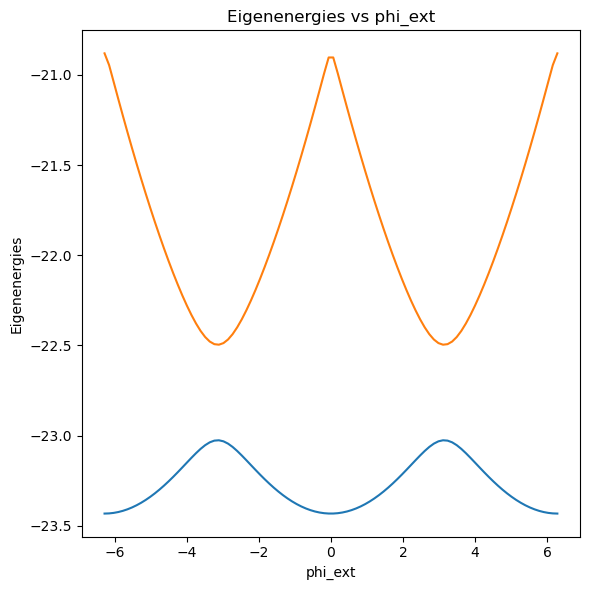

In [7]:
fixed_params = {
    'Ec': 15.41,
    'El': 0.13,
    'Delta': 40,
    'r': 0.052,
    'dimension': 100
}

phi_ext_array = np.linspace(-2*np.pi, 2*np.pi, 100)
eigenenergies, eigenstates = fb.eigensytem_vs_parameter('phi_ext', phi_ext_array, fixed_params, eigvals=2)

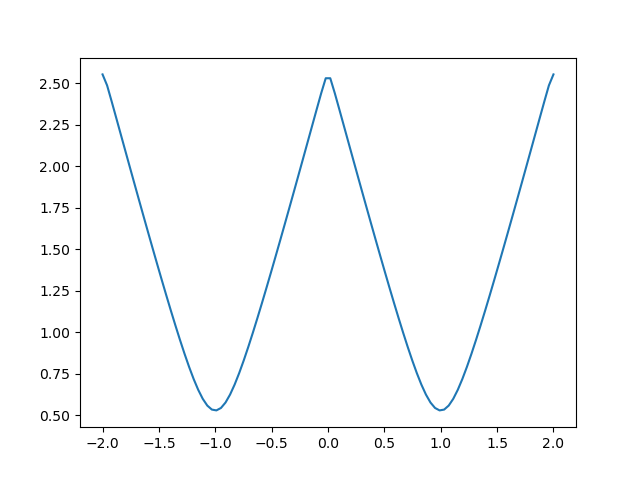

In [13]:
plt.close('all')
%matplotlib widget
plt.plot(phi_ext_array/np.pi,eigenenergies[:,1]-eigenenergies[:,0])
# plt.plot(phi_ext_array/np.pi,eigenenergies[:,2]-eigenenergies[:,1])
# plt.plot(phi_ext_array/np.pi,eigenenergies[:,2]-eigenenergies[:,0])
plt.show()

  0%|          | 0/100 [00:00<?, ?it/s]

2


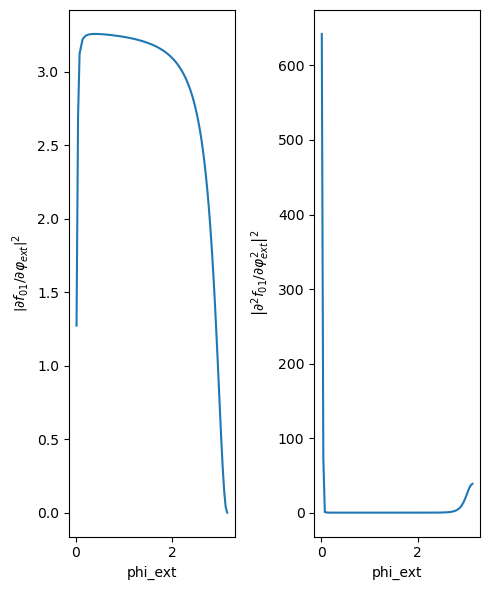

In [ ]:
fixed_params = {
    'Ec': 15,
    'El': 0.3,
    'Delta' : 40,
    'r' : 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(0.01, np.pi, 100)

first_derivative = fb.derivative_eigenenergies('phi_ext', phi_ext_array, fixed_params, eigvals=2)

  0%|          | 0/200 [00:00<?, ?it/s]

1


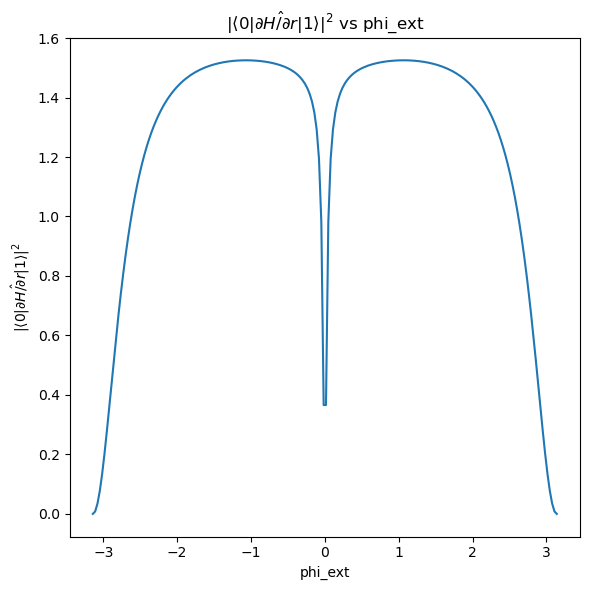

  0%|          | 0/200 [00:00<?, ?it/s]

1


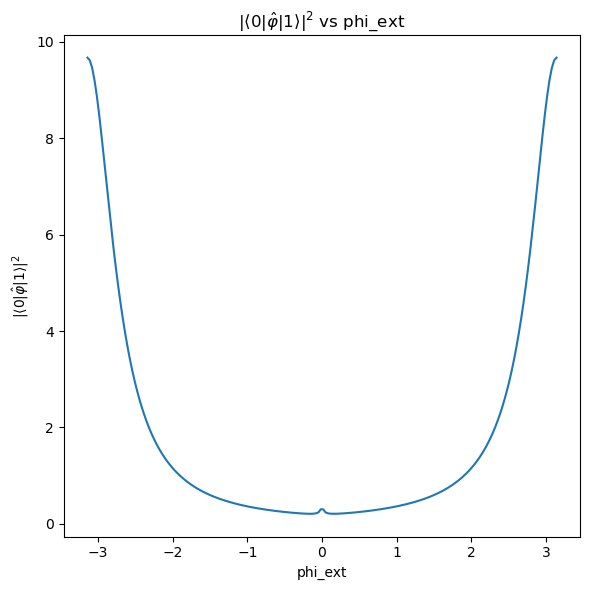

In [15]:
fixed_params = {
    'Ec': 5,
    'El': 0.05,
    'Delta': 20,
    'r': 0.05,
    'dimension': 100
}

phi_ext_array = np.linspace(-np.pi, np.pi,200)
# phi_ext_array = np.linspace(-2, 2, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='dHdr', state_i=0, state_j=1, fixed_params=fixed_params)
matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='phi_ext', parameter_values=phi_ext_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params)

In [28]:
El_array = np.logspace(np.log10(0.05), np.log10(5), num=100)
El_array

array([0.05      , 0.08340503, 0.13912797, 0.23207944, 0.38713184,
       0.64577483, 1.07721735, 1.79690683, 2.99742125, 5.        ])

  0%|          | 0/100 [00:00<?, ?it/s]

1


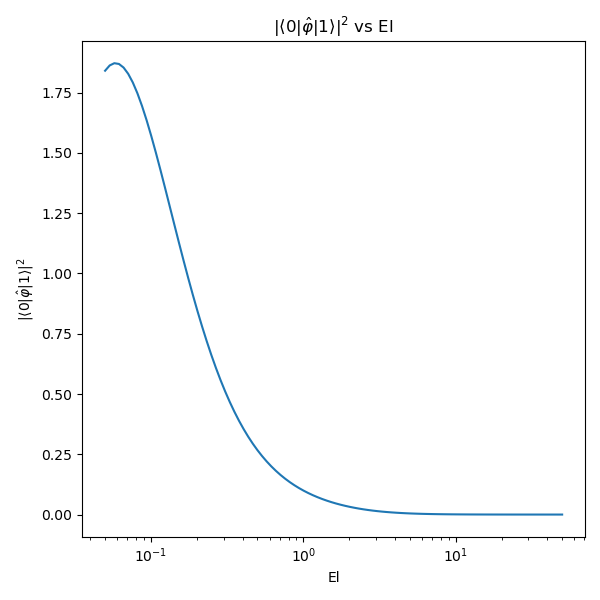

In [64]:
fixed_params = {
    'Ec': 40,
    'Delta': 20,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.geomspace(0.05, 50, 100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params, log_scale = True)

  0%|          | 0/100 [00:00<?, ?it/s]

1


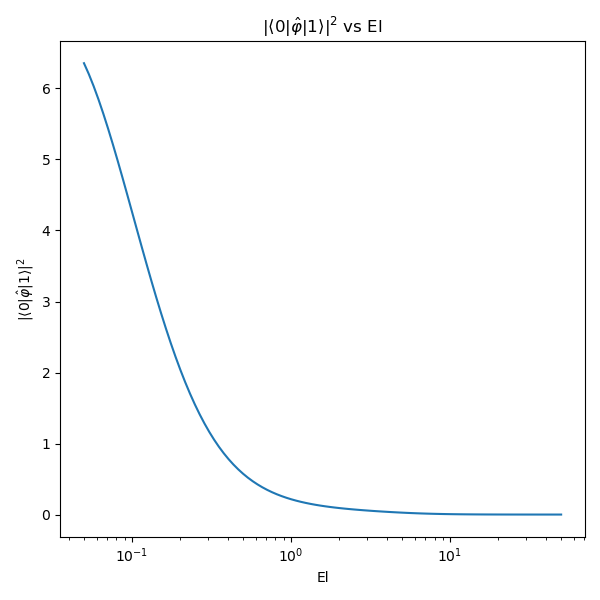

In [97]:
fixed_params = {
    'Ec': 50,
    'Delta': 40,
    'r': 0.05,
    'phi_ext': 0,
    'dimension': 100
}

El_array = np.logspace(np.log10(0.05), np.log10(50), num=100)

matrix_elements, eigenenergies = fb.matrix_elements_vs_parameter(parameter_name='El', parameter_values=El_array, operator_name='phase', state_i=0, state_j=1, fixed_params=fixed_params, log_scale = True)

# Wavefunction plot

In [14]:
params = {
    'Ec': 15.41,
    'El': 0.13,
    'Delta': 40,
    'r': 0.052,
    'phi_ext': 0.81,
    'dimension': 100
}
hamil = fb.hamiltonian(**params)
eigvals,eigvecs = hamil.eigenstates(eigvals=3)

In [15]:
phi_list=np.linspace(-5*np.pi,5*np.pi,500)
zero_down = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs[0],params['dimension']))**2
one_up = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs[1],params['dimension']))**2

zero_up = np.abs(wavefunction_phi_fbq_up(params['Ec'],params['El'],phi_list,eigvecs[0],params['dimension']))**2
one_down = np.abs(wavefunction_phi_fbq_down(params['Ec'],params['El'],phi_list,eigvecs[1],params['dimension']))**2

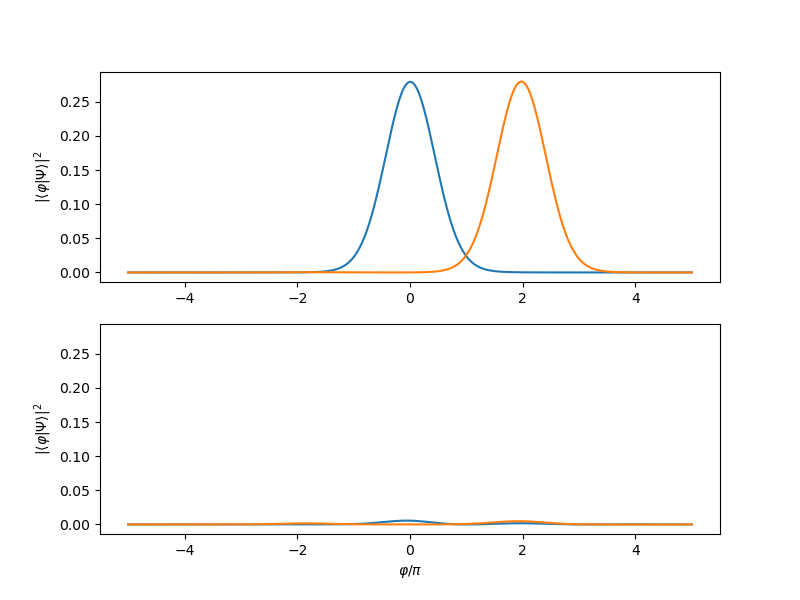

In [16]:
plt.close('all')
fig,ax = plt.subplots(2,1, figsize=(8,6), sharey=True)
ax[0].plot(phi_list/np.pi,zero_down)
ax[0].plot(phi_list/np.pi,one_up)

ax[1].plot(phi_list/np.pi,one_down)
ax[1].plot(phi_list/np.pi,zero_up)
ax[0].set_ylabel(r'$|\langle \varphi|\Psi\rangle|^2$')
ax[1].set_ylabel(r'$|\langle \varphi|\Psi\rangle|^2$')
ax[1].set_xlabel(r'$\varphi/\pi$')
plt.show()

# Optimization

In [5]:
optimization_results = []

def objective_function(params):
    # phi_ext = np.pi #to erase later
    dimension = 100
    Ec, El, Delta, r, phi_ext = params
    # Ec, El, Delta, r = params
    hamiltonian = fb.hamiltonian(Ec, El, Delta, r, phi_ext, dimension = dimension)
    eigenenergies, eigenstates = hamiltonian.eigenstates(eigvals=3)
    f10 = np.real(eigenenergies[1] - eigenenergies[0])
    f21 = np.real(eigenenergies[2] - eigenenergies[1])
    #TODO: Implement a better way to avoid anharmonicities
    # if f10 < 0.01 or f21 < 0.01:
    if f10 < 0.001 or np.abs(f21 -f10) < 0.1:
        return np.inf
    phase_operator = fb.phase_operator_total(Ec, El, dimension)
    charge_number_operator = fb.charge_number_operator_total(Ec, El, dimension)
    dHdr_operator = fb.dHdr_operator(Ec, El, r, Delta, dimension)
    phase_matrix_element = phase_operator.matrix_element(eigenstates[0], eigenstates[1])
    charge_matrix_element = charge_number_operator.matrix_element(eigenstates[0], eigenstates[1])
    dHdr_matrix_element = dHdr_operator.matrix_element(eigenstates[0], eigenstates[1])

    # Relaxation
    # capacitive_rate = np.abs(charge_matrix_element)**2 *(2*e/hbar)**2 * S_capacitive(Ec,f10)
    capacitive_rate = np.abs(charge_matrix_element)**2 * (f10/6)**(-0.7) * 1/np.tanh(1.6*f10) * (32*np.pi*Ec*1e3)
    # inductive_rate = np.abs(phase_matrix_element)**2 * S_inductive(El,f10) * (phi_0/2/np.pi/hbar)**2
    inductive_rate = np.abs(phase_matrix_element)**2 * special.k0(1.6 * f10) * np.cosh(1.6 * f10) * (4 * El / np.pi)
    # Gamma_chargeCoupledImpedance = np.abs(charge_matrix_element)**2 * S_charge_coupled_impedance(f10) *(2*e/hbar)**2
    Gamma_chargeCoupledImpedance = np.abs(charge_matrix_element)**2 *f10 * (1 + 1/np.tanh(1.6*f10)) * (4*np.pi**2/50/Rq*1e9)
    Gamma_FluxBiasLine = np.abs(phase_matrix_element)**2 * S_flux_bias_line(f10) * ((2*np.pi)**2/phi_0*El)**2
    Gamma_1overf = np.abs(phase_matrix_element)**2 * S_1f_flux(f10) * (El*(2*np.pi)**2/phi_0)**2
    Gamma_Andreev_1f = np.abs(dHdr_matrix_element)**2 * S_Andreev_1f(f10)*(2*np.pi)**2

    # Dephasing
    delta_phi_ext = 1e-2
    h_phi_plus = fb.hamiltonian(Ec, El, Delta, r, phi_ext + delta_phi_ext, dimension=dimension)
    h_phi_minus = fb.hamiltonian(Ec, El, Delta, r, phi_ext - delta_phi_ext, dimension=dimension)
    eigen_phi_plus = h_phi_plus.eigenenergies(eigvals=2)
    eigen_phi_minus = h_phi_minus.eigenenergies(eigvals=2)
    f10_phi_plus = np.real(eigen_phi_plus[1] - eigen_phi_plus[0])
    f10_phi_minus = np.real(eigen_phi_minus[1] - eigen_phi_minus[0])
    df10_dphi = (f10_phi_plus - f10_phi_minus) / (2 * delta_phi_ext)
    d2f10_dphi2 = (f10_phi_plus - 2 * f10 + f10_phi_minus) / (delta_phi_ext ** 2)

    delta_r = 1e-2
    h_r_plus = fb.hamiltonian(Ec, El, Delta, r + delta_r, phi_ext, dimension=dimension)
    h_r_minus = fb.hamiltonian(Ec, El, Delta, r - delta_r, phi_ext, dimension=dimension)
    eigen_r_plus = h_r_plus.eigenenergies(eigvals=2)
    eigen_r_minus = h_r_minus.eigenenergies(eigvals=2)
    f10_r_plus = np.real(eigen_r_plus[1] - eigen_r_plus[0])
    f10_r_minus = np.real(eigen_r_minus[1] - eigen_r_minus[0])
    df10_dphi = (f10_r_plus - f10_r_minus) / (2 * delta_r)
    d2f10_dphi2 = (f10_r_plus - 2 * f10 + f10_r_minus) / (delta_r ** 2)

    w_ir = 2*np.pi
    w_uv = 2*np.pi*3e9
    t = 10e-6

    A_phi_ext = 1.8e-6*phi_0
    first_term_phi_ext = 2*A_phi_ext**2*(df10_dphi)**2*np.abs(np.log(w_ir*t))
    second_term_phi_ext = 2*A_phi_ext**4*(d2f10_dphi2)**2 * (np.log(w_uv/w_ir)**2 + 2*np.log(w_ir*t)**2)
    dephashing_phi_ext_rate = np.sqrt(first_term_phi_ext + second_term_phi_ext)

    A_r = 2e-27
    first_term_r = 2*A_r**2*(df10_dphi)**2*np.abs(np.log(w_ir*t))
    second_term_r = 2*A_r**4*(d2f10_dphi2)**2 * (np.log(w_uv/w_ir)**2 + 2*np.log(w_ir*t)**2)
    dephashing_r_rate = np.sqrt(first_term_r + second_term_r)
    
    relaxation_rate = capacitive_rate + inductive_rate + Gamma_chargeCoupledImpedance + Gamma_FluxBiasLine + Gamma_1overf + Gamma_Andreev_1f
    dephasing_rate = dephashing_phi_ext_rate + dephashing_r_rate

    effective_rate = dephasing_rate + 0.5 * relaxation_rate
    print(effective_rate)
    return effective_rate

In [10]:
bounds = [(0.1, 50), #Ec
          (0.05, 5), #El
          (20, 40), # Delta
          (0.05, 1),#, # r
          (0, 4*np.pi)] #phi_ext

initial_guess = [15, 0.05, 40, 0.3, 0.61]
# initial_guess = [15, 0.05, 20, 0.05]

result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)

8601.972929646716
8804.457957807963
8669.00528537334
8601.972929646716
9037.217781766933
8600.477113708548
8263.010601411994
7852.409200359201
8111.497646229055
8087.053856913076
7904.210298576025
7614.374503949085
7092.857307203457
6991.154259275227
6122.583038496634
6685.094835684881
6123.896320820546
5579.673617057543
4281.666790232721
4170.502021016611
2165.499984317032
2948.518836680844
1897.262059091159
450.0437416348588
488.6155104464564
493.10706000017547
434.2840151724621
385.46323748537054
390.3566385659957
391.4879262183682
346.6781561829758
280.6386592179585
296.31000711411616
394.3809265151391
370.0461254974751
293.482604109493
262.9541666314668
207.16933144377975
200.19320184514723
125.6230041829786
300.4757870652914
267.7308120851514
167.48541244612687
134.76195086284696
95.6332256730511
53.909674740528516
7.883086565689678
21.78860745364614
109.39655451908696
14.664035780724353
2.799222577085536
6.990068659850836e-13
1.235757663368287e-10
8.231536513357488e-13
9.4523449

In [ ]:
bounds = [(0.1, 50), #Ec
          (0.05, 5), #El
          (20, 40), # Delta
          (0.05, 1),#, # r
          (0, 4*np.pi)] #phi_ext

initial_guess = [15, 0.05, 45, 0.3, 0.61]
minimizer_kwargs = {"method": "Nelder-Mead", "bounds": bounds}
result = basinhopping(objective_function, initial_guess, minimizer_kwargs=minimizer_kwargs)
# result = minimize(objective_function, initial_guess, method='Nelder-Mead', bounds=bounds)

In [7]:
result

NameError: name 'result' is not defined

In [183]:
optimized_params = result.x
optimized_value = result.fun

print("Parámetros Optimizados:", optimized_params)
print("Valor Minimizado del Elemento de Matriz:", optimized_value)

Parámetros Optimizados: [1.00000000e-01 6.74769684e-02 2.53114566e+01 3.24324646e-01
 2.47394488e-03]
Valor Minimizado del Elemento de Matriz: 7.972014863422416e-21
